Necessary imports

In [1]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import gpytorch
from gpytorch.models import ApproximateGP
from torch.distributions import Normal
import optuna
from optuna.trial import TrialState
import pickle
import pandas as pd
from sklearn.cluster import KMeans
import uncertainty_toolbox as uct

# define the device for the setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check the computer name and set the path accordingly
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])

from utils.data_prep import load_tranform_and_split_data, set_seed
from utils.metrices import evaluate_intervals

Transformation Pipeline for Approximating GPR

In [2]:
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float() # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float()
y_test_tensor = torch.from_numpy(y_test).float()
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)

if torch.cuda.is_available():
    X_train_tensor = X_train_tensor.cuda()
    X_val_tensor = X_val_tensor.cuda()
    X_test_tensor = X_test_tensor.cuda()
    y_train_tensor = y_train_tensor.cuda()
    y_val_tensor = y_val_tensor.cuda()
    y_test_tensor = y_test_tensor.cuda()

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')


Stochastic Variational GP Regression Implementation

Natural Gradient Descent with Variational Models for better and faster convergence

In [3]:
#create a TensorDataset and DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, kernel):
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module  = kernel

        self.mean_module.initialize(constant=y_train_tensor.mean().item())  # Initialize the mean to the mean of the training targets
                
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

print(y_train_tensor.var(unbiased=False).item())

58.64500427246094


Create Optuna Study

In [ ]:
def objective(trial):

    # Estimate the variance of the training targets for initializing the likelihood noise
    y_var = y_train_tensor.var(unbiased=False).item()
    noise = 1e-2 * y_var

    # Suggest hyperparameters for optimization
    lr_ngd = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
    lr_adam = trial.suggest_float('lr_adam', 1e-3, 1e-1, log=True)

    #Rational Quadratic Kernel
    rational_quadratic_kernel = gpytorch.kernels.RQKernel(ard_num_dims=X_train.shape[1], 
                                                        alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0))
    rational_quadratic_kernel.lengthscale = torch.ones(X_train.shape[1])
    rational_quadratic_kernel.outputscale = y_var
    rational_quadratic_kernel1 = gpytorch.kernels.ScaleKernel(rational_quadratic_kernel)

    kernel = rational_quadratic_kernel1

    kernel_name = type(kernel.base_kernel).__name__
    #filename = f'Modelsaves/Apprx_GP_{kernel_name}_{idx}.pth'
    print(kernel_name)

    # Define the inducing points
    # Randomly select 1000 inducing points from the training data
    num_inducing_points = 1000

    kmeans = KMeans(n_clusters=num_inducing_points, random_state=42).fit(X_train)
    inducing_points = torch.from_numpy(kmeans.cluster_centers_).float()

    model = GPModel(inducing_points = inducing_points, kernel=kernel)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise = noise

    print(f'Model: {model}')
    print(f'Mean: {model.mean_module.constant.item()}')
    print(f'Lengthscale: {model.covar_module.base_kernel.lengthscale}')
    print(f'Outputscale: {model.covar_module.outputscale}')
    print(f'Likelihood Noise: {likelihood.noise.item()}')
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    num_epochs = 100

    model.train()
    likelihood.train()

    variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data= y_train_tensor.size(0), lr=lr_ngd)

    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr=lr_adam)

    # VariationalELBO is used for training
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_loader.dataset))

    best_val_loss = np.inf
    patience = 10
    epochs_no_improve = 0
    decimal_places = 3
    tolerance = 10 ** (-decimal_places)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model.train()
        likelihood.train()
        for x_batch, y_batch in train_loader:
            # Zero gradients from previous iteration        
            variational_ngd_optimizer.zero_grad()
            hyperparameter_optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            # Print the loss for every tenth batch
            loss.backward()
            variational_ngd_optimizer.step()
            hyperparameter_optimizer.step()

            epoch_loss += loss.item()
        # print every ten epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')         # Print the average loss for the epoch

        model.eval()
        likelihood.eval()
        
        with torch.no_grad():
            f_val_preds = model(X_val_tensor)
            val_loss = -mll(f_val_preds, y_val_tensor).item()  
            
            val_preds = likelihood(f_val_preds)     
            val_mean = val_preds.mean.cpu()
            val_std = val_preds.stddev.cpu()
            val_std = val_std.clamp_min(1e-6)
            nll_per_point = -Normal(val_mean, val_std).log_prob(y_val_tensor.cpu()).numpy()
            val_nll = nll_per_point.mean().item()
            
            r2_score_val = r2_score(y_val, val_mean)
            if (epoch + 1) % 10 == 0:
                print(f'Validation Loss: {val_loss} Validation NLL: {val_nll} R²: {r2_score_val:.3f}')

            trial.report(val_loss, step=epoch)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            if abs(val_nll - best_val_loss) < tolerance:

                epochs_no_improve += 1
            else:
                epochs_no_improve = 0
                best_val_loss = val_loss
                # best_model_state = model.state_dict()
                # best_likelihood_state = likelihood.state_dict()   
            
            if epochs_no_improve >= patience:
                print(f'Early stopping at iteration {epoch + 1} with best validation loss: {best_val_loss:.3f}')
                # model.load_state_dict(best_model_state)
                # likelihood.load_state_dict(best_likelihood_state)

                break
    return best_val_loss

Execute Optuna Study

In [ ]:
print(f"Using device: {device}")

# create a study object for Optuna
study = optuna.create_study(

    direction="minimize",
    sampler=optuna.samplers.TPESampler(),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=5,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=50, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Train best Model

In [5]:
set_seed(42)
# Estimate the variance of the training targets for initializing the likelihood noise
y_var = y_train_tensor.var(unbiased=False).item()
noise = 1e-2 * y_var

#Rational Quadratic Kernel
rational_quadratic_kernel = gpytorch.kernels.RQKernel(ard_num_dims=X_train.shape[1], 
                                                    alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0)
                                                    )
rational_quadratic_kernel.lengthscale = torch.ones(X_train.shape[1])
rational_quadratic_kernel.outputscale = y_var

rational_quadratic_kernel1 = gpytorch.kernels.ScaleKernel(rational_quadratic_kernel)

kernel = rational_quadratic_kernel1

kernel_name = type(kernel.base_kernel).__name__
print(kernel_name)

# Define the inducing points
# Randomly select 1000 inducing points from the training data
num_inducing_points = 2000

kmeans = KMeans(n_clusters=num_inducing_points, random_state=42).fit(X_train)
inducing_points = torch.from_numpy(kmeans.cluster_centers_).float()

model = GPModel(inducing_points = inducing_points, kernel=kernel)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood.noise = noise

print(f'Model: {model}')
print(f'Mean: {model.mean_module.constant.item()}')
print(f'Lengthscale: {model.covar_module.base_kernel.lengthscale}')
print(f'Outputscale: {model.covar_module.outputscale}')
print(f'Likelihood Noise: {likelihood.noise.item()}')
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()

num_epochs = 100

model.train()
likelihood.train()

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data= y_train_tensor.size(0), lr=0.03)

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.04)

# VariationalELBO is used for training
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_loader.dataset))

best_val_loss = np.inf
patience = 10
epochs_no_improve = 0
decimal_places = 3
tolerance = 10 ** (-decimal_places)

for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()
    likelihood.train()
    for x_batch, y_batch in train_loader:
        # Zero gradients from previous iteration        
        variational_ngd_optimizer.zero_grad()
        hyperparameter_optimizer.zero_grad()
        output = model(x_batch)
        loss = -mll(output, y_batch)
        # Print the loss for every tenth batch
        loss.backward()
        variational_ngd_optimizer.step()
        hyperparameter_optimizer.step()

        epoch_loss += loss.item()
    # print every ten epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')         # Print the average loss for the epoch

    model.eval()
    likelihood.eval()
    
    with torch.no_grad():
        f_val_preds = model(X_val_tensor)
        val_loss = -mll(f_val_preds, y_val_tensor).item()  
        
        val_preds = likelihood(f_val_preds)     
        val_mean = val_preds.mean.cpu()
        val_std = val_preds.stddev.cpu()
        val_std = val_std.clamp_min(1e-6)
        nll_per_point = -Normal(val_mean, val_std).log_prob(y_val_tensor.cpu()).numpy()
        val_nll = nll_per_point.mean().item()
        
        r2_score_val = r2_score(y_val, val_mean)
        if (epoch + 1) % 10 == 0:
            print(f'Validation Loss: {val_loss} Validation NLL: {val_nll} R²: {r2_score_val:.3f}')

        if abs(val_nll - best_val_loss) < tolerance:

            epochs_no_improve += 1
        else:
            epochs_no_improve = 0
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            best_likelihood_state = likelihood.state_dict()   
        
        if epochs_no_improve >= patience:
            print(f'Early stopping at iteration {epoch + 1} with best validation loss: {best_val_loss:.3f}')
            model.load_state_dict(best_model_state)
            likelihood.load_state_dict(best_likelihood_state)

            break
    model.load_state_dict(best_model_state)
    likelihood.load_state_dict(best_likelihood_state)

RQKernel
Model: GPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): NaturalVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RQKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_alpha_constraint): Interval(1.000E-01, 1.000E+01)
    )
    (raw_outputscale_constraint): Positive()
  )
)
Mean: 115.00495910644531
Lengthscale: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.]], grad_fn=<SoftplusBackward0>)
Outputscale: 0.6931471824645996
Likelihood Noise: 0.6932471990585327
Epoch 10/100, Loss: 3.2129
Validation Loss: 3.306103229522705 Validation NLL: 2.7453622817993164 R²: 0.847
Epoch 20/100, Loss: 2.8599
Validation Loss: 2.9323232173919678 Validation NLL: 2.5773587226867676 R²: 0.849
Epoch 30/100, Loss: 2.7376
Validation Loss: 2.8015918731689453 Validation

Make Predictions

GPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): NaturalVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RQKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_alpha_constraint): Interval(1.000E-01, 1.000E+01)
    )
    (raw_outputscale_constraint): Positive()
  )
)
114.15072631835938
tensor([[12.4101,  7.6230,  1.7651,  1.1024,  1.4101,  1.8160,  1.2514,  1.4522,
          2.4322,  2.1292,  4.5284,  1.5132,  2.9128,  3.2097,  3.3079,  0.9506,
          3.1238,  6.4063,  1.7330,  2.0028,  4.1660,  2.9615,  1.0410,  1.1183,
          1.9145,  3.1474,  3.7330,  3.1711,  3.6772,  3.3503,  2.4020,  3.4673,
          3.1441,  3.5592,  6.0274,  8.2474,  0.4497]], device='cuda:0',
       grad_fn=<SoftplusBackward0>)
tensor(7.2961, device='cuda:0', grad_fn=<SoftplusBackward0>)
8.15279483795166
 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/

100%|██████████| 10/10 [00:02<00:00,  3.83it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.92it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.127
  RMSE          2.960
  MDAE          1.573
  MARPD         1.857
  R2            0.847
  Correlation   0.920
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.067
  Mean-absolute Calibration Error       0.059
  Miscalibration Area                   0.060
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.072
     Group Size: 0.56 -- Calibration Error: 0.063
     Group Size: 1.00 -- Calibration Error: 0.059
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.079
     Group Size: 0.56 -- Calibration Error: 0.072
     Group Size: 1.00 -- Calibration Error: 0.067
================

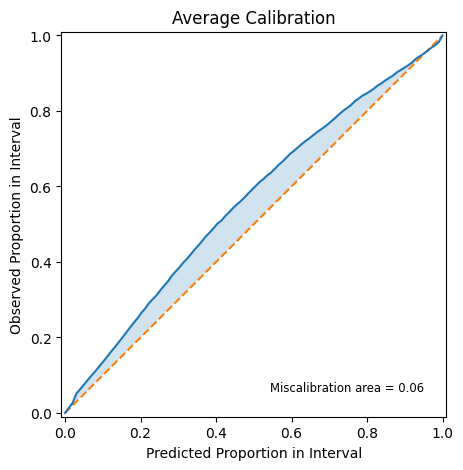

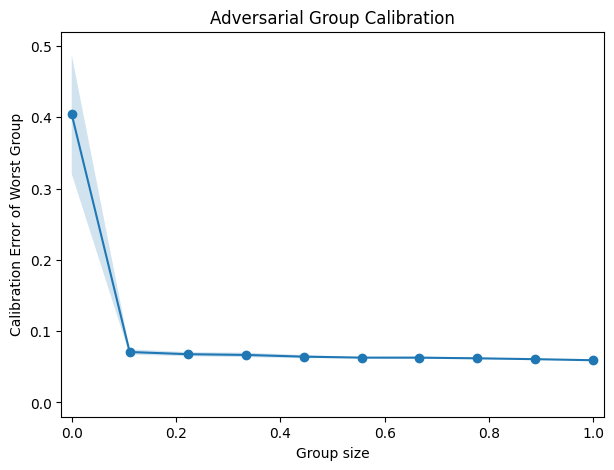

In [6]:
print(model)
print(model.mean_module.constant.item())
print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale)
print(likelihood.noise.item())
model.eval()
likelihood.eval()
means = []
variances = []
stddevs = []
with torch.no_grad():
    # Make predictions on the test set

    preds = likelihood(model(X_test_tensor))
    
    # Mean:
    means.append(preds.mean.cpu())
    
    # Variance
    variances.append(preds.variance.cpu())
    
    # Standard Deviation
    stddevs.append(preds.stddev.cpu())

means = torch.cat(means)
variances = torch.cat(variances)
stddevs = torch.cat(stddevs)  

pnn_metrics = uct.metrics.get_all_metrics(means.numpy(), stddevs.numpy(), y_test)
print(pnn_metrics)

# use own function to calculate coverage and MPIW
ev_intervals = evaluate_intervals(means.numpy(), stddevs.numpy(), y_test, coverage=0.95)
print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

# calibration Curve with UCT
uct.viz.plot_calibration(means.numpy(), stddevs.numpy(), y_test)

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(means.numpy(), stddevs.numpy(), y_test)

# check type of means, variances, stddevs
print(type(means), type(variances), type(stddevs))
print("Means shape:", means.shape)
print("Variances shape:", variances.shape)
print("Standard Deviations shape:", stddevs.shape)

Make 10 Runs with different Random Seed to evaluate GPR

In [4]:
results_list = []
predictions_list = []
list_of_seeds = [42, 123, 777, 2024, 5250, 8888, 9876, 10001, 31415, 54321]
DE_prediction_path = r"C:\Users\test\Masterarbeit\models\Modelresults\GPR"
DE_result_path = r"C:\Users\test\OneDrive\Master Management und Engineering\Masterarbeit\Experimente\Evaluation\10 Runs\GPR"

for run, seed in enumerate(list_of_seeds):

    print(f"Run {run+1} with seed {seed}")
    set_seed(seed)
    
    # Estimate the variance of the training targets for initializing the likelihood noise
    y_var = y_train_tensor.var(unbiased=False).item()
    noise = 1e-2 * y_var
    #Rational Quadratic Kernel and initialization of hyperparameters
    rational_quadratic_kernel = gpytorch.kernels.RQKernel(ard_num_dims=X_train.shape[1], 
                                                        alpha_constraint=gpytorch.constraints.Interval(0.1, 10.0)
                                                        )
    rational_quadratic_kernel.lengthscale = torch.ones(X_train.shape[1])
    rational_quadratic_kernel.outputscale = y_var
    kernel = gpytorch.kernels.ScaleKernel(rational_quadratic_kernel)
    #define the number of inducing points
    num_inducing_points = 2000
    # select inducing points with k-means
    kmeans = KMeans(n_clusters=num_inducing_points, random_state=42).fit(X_train)
    inducing_points = torch.from_numpy(kmeans.cluster_centers_).float()
    # create model and likelihood
    model = GPModel(inducing_points = inducing_points, kernel=kernel)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    # Initialize the likelihood noise
    likelihood.noise = noise
    print(f'Model: {model}')
    print(f'Mean: {model.mean_module.constant.item()}')
    print(f'Lengthscale: {model.covar_module.base_kernel.lengthscale}')
    print(f'Outputscale: {model.covar_module.outputscale}')
    print(f'Likelihood Noise: {likelihood.noise.item()}')
    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()

    num_epochs = 100
    # set the model and likelihood in training mode
    model.train()
    likelihood.train()
    # define the optimizers
    variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), num_data= y_train_tensor.size(0), lr=0.03)
    hyperparameter_optimizer = torch.optim.Adam([
        {'params': model.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr=0.04)

    # VariationalELBO is used for training
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(train_loader.dataset))

    best_val_loss = np.inf
    patience = 10
    epochs_no_improve = 0
    decimal_places = 3
    tolerance = 10 ** (-decimal_places)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model.train()
        likelihood.train()
        for x_batch, y_batch in train_loader:
            # Zero gradients from previous iteration        
            variational_ngd_optimizer.zero_grad()
            hyperparameter_optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            variational_ngd_optimizer.step()
            hyperparameter_optimizer.step()

            epoch_loss += loss.item()
        # print every ten epochs
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')         # Print the average loss for the epoch

        model.eval()
        likelihood.eval()
        
        with torch.no_grad():
            f_val_preds = model(X_val_tensor)
            val_loss = -mll(f_val_preds, y_val_tensor).item()  
            
            val_preds = likelihood(f_val_preds)     
            val_mean = val_preds.mean.cpu()
            val_std = val_preds.stddev.cpu()
            val_std = val_std.clamp_min(1e-6)
            nll_per_point = -Normal(val_mean, val_std).log_prob(y_val_tensor.cpu()).numpy()
            val_nll = nll_per_point.mean().item()

            if (epoch + 1) % 10 == 0:
                print(f'Validation Loss: {val_loss} Validation NLL: {val_nll}')

            if abs(val_nll - best_val_loss) < tolerance:

                epochs_no_improve += 1
            else:
                epochs_no_improve = 0
                best_val_loss = val_loss
                best_model_state = model.state_dict()
                best_likelihood_state = likelihood.state_dict()   
            
            if epochs_no_improve >= patience:
                print(f'Early stopping at iteration {epoch + 1} with best validation loss: {best_val_loss:.3f}')
                model.load_state_dict(best_model_state)
                likelihood.load_state_dict(best_likelihood_state)

                break

    model.eval()
    likelihood.eval()
    means = []
    stddevs = []
    with torch.no_grad():
        # Make predictions on the test set
        preds = likelihood(model(X_test_tensor))      
        # Mean:
        means.append(preds.mean.cpu())        
        # Standard Deviation
        stddevs.append(preds.stddev.cpu())

    GPR_means = torch.cat(means)
    GPR_stddevs = torch.cat(stddevs)
    #convert to numpy arrays
    GPR_means = GPR_means.numpy()
    GPR_stddevs = GPR_stddevs.numpy()

    # Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
    pnn_metrics = uct.metrics.get_all_metrics(GPR_means, GPR_stddevs, y_test)
    print(pnn_metrics)

    # use own function to calculate coverage and MPIW
    ev_intervals = evaluate_intervals(GPR_means, GPR_stddevs, y_test, coverage=0.95)
    print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

    predictions_per_run = {
        'mean_prediction': GPR_means,
        'std_prediction': GPR_stddevs,
    }

    results_per_run = {
    'RMSE': pnn_metrics['accuracy']['rmse'],
    'MAE': pnn_metrics['accuracy']['mae'],
    'R2': pnn_metrics['accuracy']['r2'], 
    'Correlation' : pnn_metrics['accuracy']['corr'],
    'NLL': pnn_metrics['scoring_rule']['nll'],
    'CRPS': pnn_metrics['scoring_rule']['crps'],
    'coverage': ev_intervals["coverage"],
    'MPIW': ev_intervals["MPIW"],
    }

    predictions_list.append(predictions_per_run)
    results_list.append(results_per_run)
#save the predictions 
with open(os.path.join(DE_prediction_path, "GPR_predictions_list.pkl"), "wb") as f:
    pickle.dump(predictions_list, f)

#save the results in an excel file
results_df = pd.DataFrame(results_list)
results_df.to_excel(os.path.join(DE_result_path, "GPR_results.xlsx"), index=False)

Run 1 with seed 42
Model: GPModel(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): NaturalVariationalDistribution()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RQKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_alpha_constraint): Interval(1.000E-01, 1.000E+01)
    )
    (raw_outputscale_constraint): Positive()
  )
)
Mean: 115.00495910644531
Lengthscale: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.]], grad_fn=<SoftplusBackward0>)
Outputscale: 0.6931471824645996
Likelihood Noise: 0.5864500403404236
Epoch 10/100, Loss: 3.3053
Validation Loss: 3.4089879989624023 Validation NLL: 2.7901203632354736
Epoch 20/100, Loss: 2.9029
Validation Loss: 2.9816935062408447 Validation NLL: 2.5944297313690186
Epoch 30/100, Loss: 2.7627
Validation Loss: 2.833674907684326 Validation NLL: 2.53

100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.119
  RMSE          2.952
  MDAE          1.576
  MARPD         1.850
  R2            0.847
  Correlation   0.921
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.064
  Mean-absolute Calibration Error       0.056
  Miscalibration Area                   0.057
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.069
     Group Size: 0.56 -- Calibration Error: 0.060
     Group Size: 1.00 -- Calibration Error: 0.056
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.076
     Group Size: 0.56 -- Calibration Error: 0.069
     Group Size: 1.00 -- Calibration Error: 0.064
================

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.116
  RMSE          2.938
  MDAE          1.584
  MARPD         1.848
  R2            0.849
  Correlation   0.921
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.064
  Mean-absolute Calibration Error       0.057
  Miscalibration Area                   0.057
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.070
     Group Size: 0.56 -- Calibration Error: 0.061
     Group Size: 1.00 -- Calibration Error: 0.057
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.076
     Group Size: 0.56 -- Calibration Error: 0.069
     Group Size: 1.00 -- Calibration Error: 0.064
================

100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.123
  RMSE          2.945
  MDAE          1.595
  MARPD         1.855
  R2            0.848
  Correlation   0.921
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.062
  Mean-absolute Calibration Error       0.055
  Miscalibration Area                   0.056
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.067
     Group Size: 0.56 -- Calibration Error: 0.059
     Group Size: 1.00 -- Calibration Error: 0.055
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.075
     Group Size: 0.56 -- Calibration Error: 0.067
     Group Size: 1.00 -- Calibration Error: 0.062
================

100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.105
  RMSE          2.920
  MDAE          1.599
  MARPD         1.838
  R2            0.851
  Correlation   0.922
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.065
  Mean-absolute Calibration Error       0.058
  Miscalibration Area                   0.059
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.070
     Group Size: 0.56 -- Calibration Error: 0.063
     Group Size: 1.00 -- Calibration Error: 0.058
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.079
     Group Size: 0.56 -- Calibration Error: 0.069
     Group Size: 1.00 -- Calibration Error: 0.065
================

100%|██████████| 10/10 [00:02<00:00,  4.02it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.94it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.112
  RMSE          2.941
  MDAE          1.579
  MARPD         1.844
  R2            0.849
  Correlation   0.921
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.065
  Mean-absolute Calibration Error       0.058
  Miscalibration Area                   0.059
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.067
     Group Size: 0.56 -- Calibration Error: 0.062
     Group Size: 1.00 -- Calibration Error: 0.058
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.075
     Group Size: 0.56 -- Calibration Error: 0.068
     Group Size: 1.00 -- Calibration Error: 0.065
================

100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.130
  RMSE          2.945
  MDAE          1.590
  MARPD         1.859
  R2            0.848
  Correlation   0.921
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.061
  Mean-absolute Calibration Error       0.054
  Miscalibration Area                   0.055
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.068
     Group Size: 0.56 -- Calibration Error: 0.058
     Group Size: 1.00 -- Calibration Error: 0.054
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.075
     Group Size: 0.56 -- Calibration Error: 0.066
     Group Size: 1.00 -- Calibration Error: 0.061
================

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.95it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.106
  RMSE          2.932
  MDAE          1.589
  MARPD         1.839
  R2            0.849
  Correlation   0.922
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.064
  Mean-absolute Calibration Error       0.057
  Miscalibration Area                   0.058
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.070
     Group Size: 0.56 -- Calibration Error: 0.061
     Group Size: 1.00 -- Calibration Error: 0.057
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.078
     Group Size: 0.56 -- Calibration Error: 0.068
     Group Size: 1.00 -- Calibration Error: 0.064
================

100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.114
  RMSE          2.934
  MDAE          1.573
  MARPD         1.847
  R2            0.849
  Correlation   0.922
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.065
  Mean-absolute Calibration Error       0.057
  Miscalibration Area                   0.058
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.072
     Group Size: 0.56 -- Calibration Error: 0.061
     Group Size: 1.00 -- Calibration Error: 0.057
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.080
     Group Size: 0.56 -- Calibration Error: 0.069
     Group Size: 1.00 -- Calibration Error: 0.065
================

100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.04it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.100
  RMSE          2.910
  MDAE          1.565
  MARPD         1.833
  R2            0.852
  Correlation   0.923
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.065
  Mean-absolute Calibration Error       0.058
  Miscalibration Area                   0.058
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.069
     Group Size: 0.56 -- Calibration Error: 0.063
     Group Size: 1.00 -- Calibration Error: 0.058
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.079
     Group Size: 0.56 -- Calibration Error: 0.070
     Group Size: 1.00 -- Calibration Error: 0.065
================

100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.105
  RMSE          2.940
  MDAE          1.566
  MARPD         1.839
  R2            0.849
  Correlation   0.922
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.067
  Mean-absolute Calibration Error       0.059
  Miscalibration Area                   0.060
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.070
     Group Size: 0.56 -- Calibration Error: 0.063
     Group Size: 1.00 -- Calibration Error: 0.059
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.080
     Group Size: 0.56 -- Calibration Error: 0.072
     Group Size: 1.00 -- Calibration Error: 0.067
================

In [5]:
DE_prediction_path = r"C:\Users\test\Masterarbeit\models\Modelresults\GPR"
DE_result_path = r"C:\Users\test\OneDrive\Master Management und Engineering\Masterarbeit\Experimente\Evaluation\10 Runs\GPR"
with open(os.path.join(DE_prediction_path, "GPR_predictions_list.pkl"), "rb") as f:
    predictions_list = pickle.load(f)

mean_list = []
std_list = []

for id, run in enumerate(predictions_list):
    # extract mean and std predictions
    mean = run['mean_prediction']
    std = run['std_prediction']
    
    # append to lists
    mean_list.append(mean)
    std_list.append(std)
    
    # calibration Curve with UCT
    uct.viz.plot_calibration(mean, std, y_test)
    plt.savefig(os.path.join(DE_result_path, f"calibration_run_{id+1}.svg"), format ='svg')
    plt.close()

    # adversarial group calibration
    uct.viz.plot_adversarial_group_calibration(mean, std, y_test)
    plt.savefig(os.path.join(DE_result_path, f"adversarial_group_calibration_run_{id+1}.svg"), format ='svg')
    plt.close()

# predictions_list enthält pro Run ein Array mit 10403 Werten
mean_matrix = np.array(mean_list)  # Shape: (n_runs, 10403)
std_matrix = np.array(std_list)    # Shape: (n_runs, 10403)

# Mittelwert und Std für jeden Datenpunkt über alle Runs
mean_per_datapoint = np.mean(mean_matrix, axis=0)  # Shape: (10403,)
std_per_datapoint = np.mean(std_matrix, axis=0)    # Shape: (10403,)

# calibration Curve with UCT
uct.viz.plot_calibration(mean_per_datapoint, std_per_datapoint, y_test)
plt.savefig(os.path.join(DE_result_path, "calibration_run_mean.svg"), format ='svg')
plt.close()

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(mean_per_datapoint, std_per_datapoint, y_test)
plt.savefig(os.path.join(DE_result_path, "adversarial_group_calibration_run_mean.svg"), format ='svg')
plt.close()